# Partial Differential Equations 3: Coursework

Complete all the questions below in the sections marked 'Solution'. Then convert this page to a pdf file by using 'File/Print Preview'. Then click on the dotted symbol at the top-right of your webpage and choose 'Print', or press 'Ctrl+P', and save your document as a pdf file. Make sure you select 1 page per sheet in the 'more settings' section. Then submit your pdf file via Learn to the Coursework dropbox.

Do not alter the standard format of this Jupyter Notebook. Marks for this coursework will be awarded for the correctness of the solution as well as for the clarity and logical progression of your explanation and your presentation and layout of the solution. You will need to write equations using LaTeX embedded within this Jupyter Notebook. See this notebook and other tutorial or computing workbooks for examples of how this is achieved. Tutorials can also be found online. You will also need to add or complete code 'snippets' using separate code sections within this Notebook.


## Q1 (50 marks)

Consider the one-dimensional heat conduction equation

\begin{align}
\frac{\partial u(x,t)}{\partial t} &= \kappa \frac{\partial^2 u(x,t)}{\partial x^2} \tag{a}
\end{align}

on the interval $0<x<0.5\pi$ with the initial condition 

$$u(x,0) = \sin(x), \quad 0\le x< 0.5\pi, \tag{b} $$

and the boundary conditions

\begin{align}
u(0,t) &= g_0(t), \quad \forall t\ge0, \tag{c} \\
u(0.5\pi, t)&= g_1(t), \quad \forall t\ge0. \tag{d} 
\end{align}

__a)__ By using the Laplace transform method with respect to time $t$ show that the Laplace domain solution is

\begin{align}
U(x,s) =& \frac{G_1(s) - \frac{1}{s+\kappa}}{\sinh\left(0.5\pi\sqrt{\frac{s}{\kappa}}\right)}\sinh\left(x\sqrt{\frac{s}{\kappa}}\right) + \frac{G_0(s)}{\sinh\left(0.5\pi\sqrt{\frac{s}{\kappa}}\right)}\sinh\left((0.5\pi-x)\sqrt{\frac{s}{\kappa}}\right) + \frac{\sin(x)}{s + \kappa}
\end{align}

where $G_0(s)$ and $G_1(s)$ are the laplace transforms of $g_0(t)$ and $g_1(t)$ respectively.
\
\
__Solution (25 marks)__


__b)__ Now consider the specific boundary conditions

\begin{align}
u(0,t) &= g_0(t) = t, \quad &\forall t\ge0,\\
u(0.5\pi, t)&= g_1(t) = \exp(-\kappa t), \quad &\forall t\ge0.
\end{align}

Find the time domain solution.

__Hint:__

The Laplace domain function

$$
F(s) = \frac{\sinh(b\sqrt{s})}{s^2\sinh(a\sqrt{s})}
$$

has the inverse transform
\begin{align}
f(t) =& \frac{bt}{a} + \frac{2a^2}{\pi^3} \sum_{n=1}^\infty \frac{(-1)^n}{n^3}\left(1 - e^{-n^2\pi^2 t/a^2}\right) \sin\left(\frac{n\pi b}{a}\right)
\end{align}
\
\
__Solution (15 marks)__

\
\
__c)__ Provide a 3-d plot of your solution below for $\kappa=0.2$ between $0\le t\le 5$. __(10 marks)__

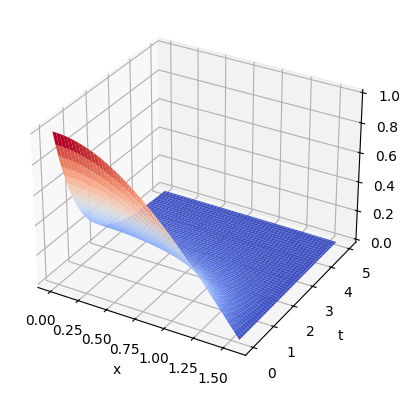

In [7]:
# PLOT YOUR SOLUTION HERE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

x_ord = np.linspace(0, np.pi/2, 100)
t_ord = np.linspace(0, 5, 100)
x, t = np.meshgrid(x_ord,t_ord)

def Solution(x,t):
    return np.cos(x) * np.exp(-t)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_surface(x, t, Solution(x,t),cmap=cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.show()

## Q2 (50 marks)

You are to use the two dimensional form of the Crank-Nicholson method to solve the isotropic heat conduction equation,

$$\frac{\partial T}{\partial t} = \kappa\left(\frac{\partial^2 T}{\partial x^2}+\frac{\partial^2 T}{\partial y^2}\right).$$

The <code>Grid</code> class, below, will be used to generate the grid for this solver. It has been extended to include an additional variable for time (<code>self.time</code>) in the grid object and to ensure that this is zero when the grid is created. The time variable will be needed later by the boundary condition routines.  The class also includes <code>self.kappa</code> variable, which is used to store the thermal diffusivity. 

The problem addressed with its boundary conditions is presented below after the definition of the Grid class.

The <code>class Grid</code> code is complete, while for the rest of the problem, parts of Python code are provided with certain sections missing, which are for you to fill in. 


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import time

class Grid:
    '''Class defining a 2D computational grid.  The grid object
    contains is a regular cartesian grid with a single variable, u.
    It stores information about the number of grid points in the i
    and j directions, the coordinates of these points and the bottom
    left corner of the grid (the origin) and the top right corner
    (the extent).
    
    Written by Prof David Ingram, School of Engineering
    (c) 2022 The University of Edinburgh
    Licensed under CC-BY-NC.'''
    
    DIRICHLET_BC = 0
    NEUMANN_BC = 1

    BC_NAME = ['left', 'right', 'top', 'bottom']
    
    def __init__(self,ni,nj):
        # Set up information about the grid
        self.origin = (0.0, 0.0)  # bottom left
        self.extent = (1.0, 1.0)  # top right
        self.Ni = ni # grid points in i direction
        self.Nj = nj # grid points in j direction
        
        # Initialse x,y and u arrays
        self.u = np.zeros((nj, ni))
        self.x = np.zeros((nj, ni))
        self.y = np.zeros((nj, ni))
        
        # Boundary conditions (left right top and bottom)
        self.BC = [self.DIRICHLET_BC, self.DIRICHLET_BC, 
                   self.DIRICHLET_BC, self.DIRICHLET_BC]
        
        # Set the time
        self.time = 0.0
        
        # Initialize thermal diffusivity
        self.kappa = 1.0

    def set_origin(self,x0,y0):
        
        # Set origin of domain
        self.origin = (x0, y0)
    
    def set_extent(self,width,height):
        
        # Set extent of domain
        self.extent = (width, height)
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        origin to the extent.  We are going to do this using linspace from
        numpy to create lists of x and y ordinates and then the meshgrid
        function to turn these into 2D arrays of grid point ordinates.'''
        x_ord = np.linspace(self.origin[0], self.origin[0]+self.extent[0], self.Ni)
        y_ord = np.linspace(self.origin[1], self.origin[1]+self.extent[1], self.Nj)
        self.x, self.y = np.meshgrid(x_ord,y_ord)
        if not Quiet:
            print(self)

    def set_diffusivity(self,k):
        self.kappa = k
        
    def Delta_x(self):
        # Calculate delta x
        dx = self.x[0,1]-self.x[0,0]
        
        return dx
    
    def Delta_y(self):
        # Calculate delta y
        dy = self.y[1,0]-self.y[0,0]
        
        return dy
    
    def find(self,point):
        '''find the i and j ordinates of the grid cell which contains 
        the point (x,y).  To do this we calculate the distance from
        the point to the origin in the x and y directions and then
        divide this by delta x and delta y.  The resulting real ordinates
        are converted to indices using the int() function.'''
        grid_x = (point[0] - self.origin[0])/self.Delta_x()
        grid_y = (point[1] - self.origin[1])/self.Delta_y()
        return int(grid_x), int(grid_y)
    
    def set_Neumann_bc(self,side):
        try:
             self.BC[self.BC_NAME.index(side)] = self.NEUMANN_BC
        except:
             print('error {} must be one of {}'.format(side,self.BC_NAME))
     
    def set_Dirichlet_bc(self,side):
        try:
            self.BC[self.BC_NAME.index(side)] = self.DIRICHLET_BC
        except:
            print('error {} must be one of {}'.format(side,self.BC_NAME))
    
    def plot(self,title):
        '''produce a contour plot of the solution at the current time'''
        
        # Create a figure title
        caption = f'{title}, t={self.time}s ({self.Ni} x {self.Nj}) grid.'
        
        # Create a figure and add a plot to it
        fig, ax1 = plt.subplots()
        
        # Draw the contour plot
        cmap = plt.get_cmap('jet')
        cf = ax1.contourf(self.x,self.y,self.u,cmap=cmap, levels = 21)
        
        # Add colorbar
        fig.colorbar(cf, ax=ax1)
        
        # Set titlea
        ax1.set_title(caption)
        return plt

     
    def report_BC(self):
        '''compile a string listing the boundary conditions on each side.
        We build up a string of four {side name}: {BC type} pairs and
        return it'''
        
        # Initialise the string
        string = ''
        
        # loop over the sides
        for side in range(4):
            # Add the side name
            string = string + self.BC_NAME[side]
            # And the boundary condition type
            if self.BC[side] == self.DIRICHLET_BC:
                string = string + ': Dirichlet, '
            elif self.BC[side] == self.NEUMANN_BC:
                string = string + ': Neumann, '
        return string[:-2] +'.' # Lose the last comma and space.
    
    def __str__(self):
        # Description of the object when asked to print it
        describe = 'Uniform {}x{} grid from {} to {}.'.format(self.Ni, self.Nj, self.origin, self.origin+self.extent)
        boundaries = self.report_BC()
        return describe + '\n The boundary conditions are - ' + boundaries +f'\ntime ={self.time:.4g}'
    

## The problem
The following PDE is to be solved
$$
\frac{\partial u(x,y,t)}{\partial t} = \kappa \left(\frac{\partial^2 u(x,y,t)}{\partial x^2}+\frac{\partial^2 u(x,y,t)}{\partial y^2}\right)
$$
on the interval $$0\le x\le0.5\pi \\ -\pi \le y\le \pi$$ with the initial condition
$$
u(x,y,0) = \sin(x)  \quad\quad 0\le x \le0.5\pi \; , \;-\pi\le y\le \pi
$$
and the boundary conditions

$$\begin{align}
u(0,y,t) &= t &\quad \forall t\ge0, \qquad &-\pi\le y\le \pi, \\
u\left(0.5\pi,y,t\right) &= \exp(-\kappa t) &\quad \forall t\ge0, \qquad &-\pi\le y\le \pi, \\
u\left(x,-\pi,t\right) &= 0 &\quad \forall t\ge0, \qquad &0\le x \le0.5\pi, \\
u\left(x, \pi,t\right) &= 2\cos(x)\exp(-\kappa t) &\quad \forall t\ge0, \qquad &0\le x \le0.5\pi, \end{align}$$


As in the analytical part, $\kappa=0.2$.

__a)__ Set up the grid, the initial and boundary conditions by completing the __Python__ code below. Explain how the boundary conditions are implemented in the code. __(10 marks)__



<module 'matplotlib.pyplot' from '/Users/ben/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

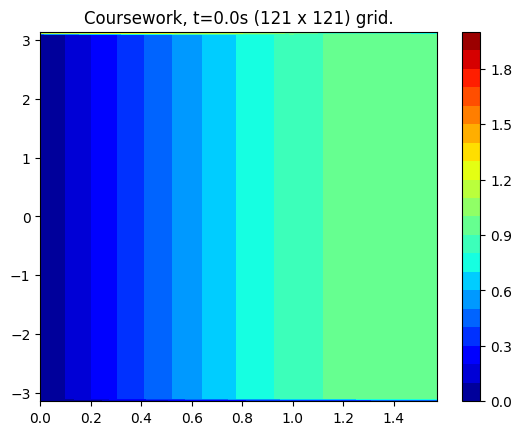

In [117]:
def set_grid(ni,nj):
    ''' This function sets up an ni x nj grid to solve the problem specified in the Coursework'''
    
    # Initialize the grid class with ni and nj grid points
    mesh = Grid(ni,nj)
    
    # Set origin and extent of grid
    mesh.set_origin(0, -np.pi)
    mesh.set_extent(np.pi * 0.5, 2*np.pi)
    
    # Set diffusivity
    mesh.set_diffusivity(0.2)
    
    # This generates the grid
    mesh.generate()
     
    # Now set the inital conditions
    mesh.u = np.sin(mesh.x)
    
    return mesh

def set_boundary_conditions(mesh,time):
    '''Function that sets the boundary conditions. This functions takes 
       as input a mesh (mesh) and a time step (time)'''
    
    # Set x = 0 boundary
    mesh.u[:,0] = time
    
    # Set x = 0.5pi boundary
    mesh.u[:,-1] = np.exp(-mesh.kappa * time)
    
    # Set y = -pi boundary
    mesh.u[0,:] = 0

    # Set y = pi boundary
    mesh.u[-1,:] = 2 * np.cos(mesh.x[-1,:]) * np.exp(-mesh.kappa * time)

# This creates a 121 by 121 grid
grid = set_grid(121, 121)

# Call the function to set up boundary conditions for the first time step (t=0)
set_boundary_conditions(grid, 0.0)

# Plot the initial solution matrix - Check that initial and boundary conditions are implemented correctly!
grid.plot('Coursework')


### Boundary & Initial Condition Implementation

The initial condition is implemented in: `mesh.u = np.sin(mesh.x)`. Here, the $u$ value of every point in the mesh (`mesh.u`) is equal to the sine of the $x$ value of that point (`mesh.x`).

The boundary conditions are implemented by overwriting the $u$ values on the boundaries of the mesh to match the corresponding condition. These value are accessed via `mesh.u[j,i]` where $j=0$ corresponds to the bottom row and $i=0$ corresponds to the leftmost column (conversely $j=-1$ and $i=-1$ correspond to the top row and rightmost column respectively). From there, the $u$ values are equated to the boundary conditions, referencing the `mesh.x`, `mesh.kappa`  and `time` variables when necessary:

- `mesh.u[:,0] = time`
> sets the left boundary equal to the `time` value
- `mesh.u[:,-1] = np.exp(-mesh.kappa * time)`
> sets the right boundary equal to $\exp(-\kappa t)$
- `mesh.u[0,:] = 0`
> sets the bottom boundary to zero
- `mesh.u[-1,:] = 2 * np.cos(mesh.x[-1,:]) * np.exp(-mesh.kappa * time)`
> sets the top boundary equal to $2\cos(x)\exp(-\kappa t)$



__b)__ Derive the 2D Crank-Nicholson scheme by using the appropriate finite difference approximations of the derivatives, stating its formal order of accuracy in time and space. Specify also the coefficients of the solution at the current point and its neighbouring points in the 2D Crank-Nicholson equation. This part requires writing the equations to derive the 2D Crank-Nicholson scheme and does not involve writing Python code. __(10 marks)__

__Solution__



Consider the equation
$$
\frac{\partial u}{\partial t} = \kappa\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)
$$
here, the finite difference of the partial derivatives are
$$
\frac{\partial u}{\partial t} \approx \frac{u^{n+1}_{i,j}-u^{n}_{i,j}}{\Delta t} \\
\frac{\partial^2 u}{\partial x^2} \approx \frac{u^{n}_{i+1,j} - 2u^{n}_{i,j} + u^{n}_{i-1,j}}{\Delta x^2} \\
\frac{\partial^2 u}{\partial y^2} \approx \frac{u^{n}_{i,j+1} - 2u^{n}_{i,j} + u^{n}_{i,j-1}}{\Delta y^2} \\
$$
These can be subsituted into the first equation to form the explicit parabolic time-stepping scheme:
$$
\frac{u^{n+1}_{i,j}-u^{n}_{i,j}}{\Delta t} = \kappa\left(\frac{u^{n}_{i+1,j} - 2u^{n}_{i,j} + u^{n}_{i-1,j}}{\Delta x^2}+\frac{u^{n}_{i,j+1} - 2u^{n}_{i,j} + u^{n}_{i,j-1}}{\Delta y^2}\right)
$$
To make the scheme implicit, it must incorporate data from current time step as well as the past time step:
$$
(1-\alpha)\frac{\partial^2 u}{\partial x^2} \Bigg|_{i,j}^n + \alpha \frac{\partial^2 u}{\partial x^2} \Bigg|_{i,j}^{n+1} \\
(1-\alpha)\frac{\partial^2 u}{\partial y^2} \Bigg|_{i,j}^n + \alpha \frac{\partial^2 u}{\partial y^2} \Bigg|_{i,j}^{n+1} \\
$$
Applying this to the explicit method and setting $\alpha = \frac{1}{2}$ yields the Crank-Nicholson scheme in 2D:
$$
\frac{u^{n+1}_{i,j}-u^{n}_{i,j}}{\Delta t} = \kappa\left(\frac{u^{n}_{i+1,j} - 2u^{n}_{i,j} + u^{n}_{i-1,j}}{2\Delta x^2}+\frac{u^{n+1}_{i+1,j} - 2u^{n+1}_{i,j} + u^{n+1}_{i-1,j}}{2\Delta x^2}+\frac{u^{n}_{i,j+1} - 2u^{n}_{i,j} + u^{n}_{i,j-1}}{2\Delta y^2}+\frac{u^{n+1}_{i,j+1} - 2u^{n+1}_{i,j} + u^{n+1}_{i,j-1}}{2\Delta y^2}\right)
$$
Rearranging to group past and present terms yields an equation that can be solved for simultaneously for each point. To aid in this, we define $r_x = \frac{\kappa \Delta t}{\Delta x^2}$ and $r_y = \frac{\kappa \Delta t}{\Delta y^2}$
$$
-\frac{r_x}{2} u^{n+1}_{i+1,j} -\frac{r_y}{2} u^{n+1}_{i,j+1} + (1+r_x+r_y)u^{n+1}_{i,j} - \frac{r_x}{2} u^{n+1}_{i-1,j} - \frac{r_y}{2} u^{n+1}_{i,j-1} = \frac{r_x}{2} u^{n}_{i+1,j} + \frac{r_y}{2} u^{n}_{i,j+1} + (1-r_x-r_y)u^{n}_{i,j} + \frac{r_x}{2} u^{n}_{i-1,j} + \frac{r_y}{2} u^{n}_{i,j-1}
$$
This can be written as
$$
-\frac{r_x}{2} u^{n+1}_{i+1,j} -\frac{r_y}{2} u^{n+1}_{i,j+1} + (1+r_x+r_y)u^{n+1}_{i,j} - \frac{r_x}{2} u^{n+1}_{i-1,j} - \frac{r_y}{2} u^{n+1}_{i,j-1} = b^n_{i,j}
$$
where
$$
b^n_{i,j} = \frac{r_x}{2} u^{n}_{i+1,j} + \frac{r_y}{2} u^{n}_{i,j+1} + (1-r_x-r_y)u^{n}_{i,j} + \frac{r_x}{2} u^{n}_{i-1,j} + \frac{r_y}{2} u^{n}_{i,j-1}
$$


__c)__ Complete the following __Python__ code which implements the Crank-Nicholson solver in 2D using the Bi-conjugate gradient stabilised linear algebra solver. __(20 marks)__

In [119]:
def Crank_Nicholson(mesh,t_stop,Courant_no=5.0):
    '''Advance the solution from the current time to t=t_stop
    using the Crank-Nicholson method.
    
    mesh is an object of the grid class, 
    t_stop is the time at which the solution is required and 
    Courant_no is the Courant number to be used for the calculation.  
    While the Crank-Nicholson method is unconditionally stable, a low
    Courant number is recommended on grounds of accuracy.'''
    
    # Calculate delta_t based on the Courant Number 
    delta_t = Courant_no*min(mesh.Delta_x()**2, mesh.Delta_y()**2)/(2*mesh.kappa)
    
    # Calculate number of iterations based on stopping time t_stop and time step delta_t
    maxit = int((t_stop-mesh.time)/delta_t)
    
    # We set a variable of every how many iterations (time steps) to report
    out_it = maxit // 50
    
    print('Crank Nicholson with ∆t={:.4g} ({:d} times steps)'.format(delta_t,maxit))
    
    # Initialize the A matrix using the lil format (sparse matrix) and the b vector as a numpy vector.
    N = (grid.Nj-2)*(grid.Ni-2) # How many interior points our solution grid has
    A_mat = sps.lil_matrix((N, N), dtype=np.float64)
    b_vec = np.zeros(N, dtype=np.float64)
    
    # Initialize the solution vector
    x_vec = np.zeros(N, dtype=np.float64)
    

    # Calculate rx and ry coefficients
    rx = mesh.kappa * delta_t / mesh.Delta_x()**2
    ry = mesh.kappa * delta_t / mesh.Delta_y()**2

    # Now build the A and B matricies
    for i in range(1,mesh.Ni-1):
        for j in range(1,mesh.Nj-1):
            # We introduce index k
            k = (i-1) + (mesh.Ni-2)*(j-1)
                
            # Set the leading diagonal coefficient
            A_mat[k,k] = (1+rx+ry)
               
            # Set coefficients of neighbouring points in the i direction
            for m in range(i-1,i+2,2):
                if not(m<1 or m>mesh.Ni-2):
                    l = (m-1) + (mesh.Ni-2)*(j-1)
                    A_mat[k,l] = -rx/2

            # Set coefficients of neighbouring points in the j direction
            for m in range(j-1,j+2,2):
                if not(m<1 or m>mesh.Nj-2):
                    l = (i-1) + (mesh.Ni-2)*(m-1)
                    A_mat[k,l] = -ry/2
    
    # Assemble the preconditioner
    ilu = LA.spilu(A_mat.tocsc(), drop_tol=1e-6, fill_factor=100)
    M_mat = LA.LinearOperator(A_mat.shape, ilu.solve)

    # Set an iteration counter
    it = 0
    
    # Set a variable for the convergence status. This is set initially to 1, which means convergence not achieved. 
    # The LA.bicgstab will return status = 0 when we have successful convergence.
    status = 1
    
    # Start the time loop - Every iteration is a time step
    while mesh.time < t_stop:
        
        # Progress counter
        if it % out_it ==0:
            print('#',end='')
            
        # Calculate time step dt - Ensure we don't overshoot the stop time
        dt = min(delta_t, t_stop-mesh.time)
        
        # Set the boundary conditions
        set_boundary_conditions(mesh, mesh.time)
        
        # Extract the x_vector - We take the interior points of the 2D solution array (mesh.u[1:-1,1:-1]) and we reshape
        # that into a vector (1D array) with N elements
        x_vec = np.reshape(mesh.u[1:-1,1:-1],(N))

        # Calculate the b vector (RHS) using the values from the current time step
        for i in range(1,mesh.Ni-1):
            for j in range(1,mesh.Nj-1):
                k = (i-1) + (mesh.Ni-2)*(j-1)
                
                # Calculate b(k) from the stencil for the current time step
                b_vec[k] = (rx/2) * mesh.u[j, i+1] + (ry/2) * mesh.u[j+1, i] + (1 - rx - ry) * mesh.u[j, i] + (rx/2) * mesh.u[j, i-1] + (ry/2) * mesh.u[j-1, i]
 
        # Now apply the boundary conditions for the next time level
        set_boundary_conditions(mesh, mesh.time+dt)
        
        # Update the b vector to include boundary conditions
        for i in range(1,mesh.Ni-1):
            for j in range(1,mesh.Nj-1):
                k = (i-1) + (mesh.Ni-2)*(j-1)
                
                # i direction
                for m in range(i-1,i+2,2):
                    if m<1 or m>mesh.Ni-2:
                        b_vec[k] += rx/2 * mesh.u[j,m]

                # j direction
                for m in range(j-1,j+2,2):
                    if m<1 or m>mesh.Nj-2:
                        b_vec[k] += ry/2 * mesh.u[m,i]
                        
        # Solve the matrix system Ax=b using the preconditioner M
        x_vec, status = LA.bicgstab(A_mat, b_vec, x0=x_vec, M=M_mat)
        
        # If status=0 is returned then we have convergence. If not, convergence not achieved and we break the loop
        if status==0:
            # Out solution is in the format of a vector (x_vec - 1D array). We need to unpack this into a 2D grid (2D array)
            mesh.u[1:-1,1:-1] = np.reshape(x_vec, (mesh.Ni-2,mesh.Nj-2))
        if status != 0:
            break
        
        # Update time step and iteration number for next step
        mesh.time += dt
        it += 1
    
    print('.')
    if status == 0:
        return it
    else:
        return -status

__d)__ Calculate the solution at time $t=5$ s.  Compare the numerical solution at $y=0$ with the analytical solution from question Q1. Comment on the accuracy of the method and the computational effort needed. __(10 Marks)__

Crank Nicholson with ∆t=0.002142 (2334 times steps)
###################################################.
2335 iterations completed.


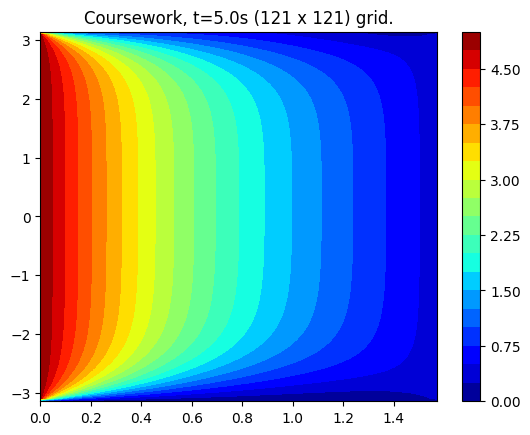

In [122]:
# This creates a 121 by 121 grid
grid = set_grid(121, 121)

# Call the function to set up boundary conditions for the first time step (t=0)
set_boundary_conditions(grid, 0.0)

it = Crank_Nicholson(grid, 5)

# Prints how many iterations were performed
print(it,'iterations completed.')

# Plots solution
fig = grid.plot('Coursework')
fig.show()

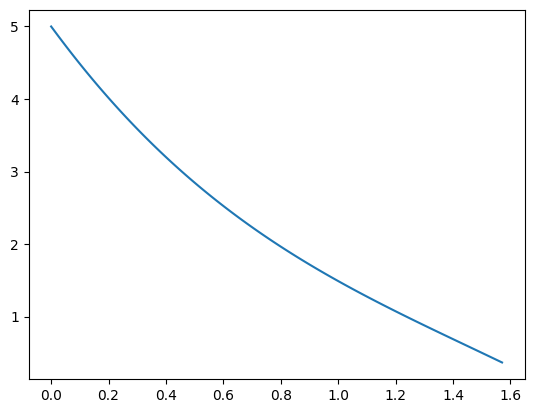

In [150]:
# Compare numerical and analytical solution
numerical = np.array([grid.x[0,:], grid.u[int((grid.Nj-1)/2), :]])
plt.plot(numerical[0], numerical[1])

Write your comments for 2d) here...



$\\[3cm]$

__Properties of the unilateral Laplace transform__

|Property | $f(t), t\ge0$ | $F(s)$ |
| :-: | :-: | :-: |
|Definition | $f(t)$ | $\int_0^\infty\exp(-st)f(t)dt$ |
|Inversion | $\frac{1}{j2\pi}\int_{c-j\infty}^{c+j\infty} \exp(st)F(s)ds$ | $F(s)$ |
|Linearity | $\alpha f(t) + \beta g(t)$ | $\alpha F(s) + \beta G(s)$ |
|Scaling | $f(\alpha t)$ | $\frac{1}{\alpha}F\left(\frac{s}{\alpha}\right)$ |
|Frequency shifting | $\exp(\alpha t)f(t)$ | $F(s-\alpha)$ |
|Time shifting | $f(t-\alpha) H(t-\alpha)$ | $\exp(-\alpha s)F(s)$ |
|First derivative | $f'(t)$ | $sF(s) - f(0)$ |
|nth derivative | $f^{(n)}(t)$ | $s^nF(s)-s^{n-1}f(0)-s^{n-2}f'(0) \dots -s f^{(n-2)}(0) - f^{(n-1)}(0)$ |
|Transform derivative | $t^n f(t)$ | $(-1)^n \frac{d^n F(s)}{ds^n}$ |      
|Integration | $\int_0^t f(\tau)d\tau$ | $\frac{1}{s}F(s)$ |

__Function transforms__

|Name | $f(t), t\ge0$ | $F(s)$ | Convergence region |
| :-: | :-: | :-: | :-: |
|Unit impulse | $\delta(t)$ | $1$ | all $s$ |
|Ideal delay | $\delta(t-\alpha)$ | $\exp(-\alpha s)$ | $\Re(s)\ge\alpha$ |
|Unit step | $H(t)$ | $\frac{1}{s}$ | $\Re(s)>0$ |
|Ramp  | $t$ | $\frac{1}{s^2}$ | $\Re(s)>0$ |
|nth power  | $t^n, n=1,2,\dots$ | $\frac{n!}{s^{n+1}}$ | $\Re(s)>0$ |
|Sine | $\sin(\alpha t)$ | $\frac{\alpha}{s^2 + \alpha^2}$ | $\Re(s)>0$ |
|Cosine | $\cos(\alpha t)$ | $\frac{s}{s^2 + \alpha^2}$ | $\Re(s)>0$ |
|Hyperbolic sine | $\sinh(\alpha t)$ | $\frac{\alpha}{s^2 - \alpha^2}$ | $\Re(s)>|\alpha|$ |
|Hyperbolic cosine | $\cosh(\alpha t)$ | $\frac{s}{s^2 - \alpha^2}$ | $\Re(s)>|\alpha|$ |
|Exponential decay | $\exp(-\alpha t)$ | $\frac{1}{s + \alpha}$ | $\Re(s)>-\alpha$ |
|First moment of exponential decay | $t\exp(-\alpha t)$ | $\frac{1}{(s + \alpha)^2}$ | $\Re(s)>-\alpha $ |
|Ramp hyperbolic sine | $t\sinh(\alpha t)$ | $\frac{2\alpha s}{(s^2 - \alpha^2)^2}$ | $\Re(s)>|\alpha|$ |
|Complementary error function  | $\text{erfc}\left(\frac{k}{2\sqrt{t}}\right)$ | $\frac{1}{s}\exp\left(-k\sqrt{s}\right)$ | $\Re(s)\ge0$ |